In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
import pickle
from tqdm import tqdm
from itertools import chain

In [4]:
def DataClean(data_path,labels_path,write_path=None,delete=None):
    
    '''
    data_path: the file containing the notes.
    labels_path: the file containing the titles.
    write_path: the destination pkl file for writing the result.
    delete: whether to delete the useless infomation like name etc..
    '''
    
    print('\n\nImporting and filtering database...')
    notes = pd.read_csv(data_path)
    ints_str = '0123456789-#[]' # characters that usually main categories don't start with
    
    print('\n\nSplitting each note into sections:\n\n')
    notes_sections = {}
    for note_index in tqdm(range(notes.shape[0])):
        note = notes['text'][note_index].replace('\n\n\n\n','\n').replace('\n\n\n','\n').replace('     ','\n')
        paragraphs = note.split('\n')
        
        subsections, new_section = [], ' '
        for p in paragraphs:
            line = p.strip()
            if len(line)>0 and ':' in line and not (line[line.find(':')-1] in ints_str) and not(line[0] in ints_str):
                subsections.append([new_section.strip()])
                new_section = p + ' '
            else:
                new_section += p + ' '
        subsections.append([new_section])
        subsections.pop(0)

        note_sect_tit,note_sect_par = [],[]
        for sect in subsections:
            note_sect_tit += [str(*sect)[0:str(*sect).find(':')]]
            note_sect_par += [str(*sect)[str(*sect).find(':')+1:].strip()]
        note_df = pd.DataFrame({'title':note_sect_tit,'category':'','text':note_sect_par, 'label':''})
        notes_sections[notes['note_id'][note_index]] = note_df
    
    f = open(labels_path, 'r')
    obj_label = f.readlines()
    obj_label_dict = {}
    i = 0
    for s in obj_label:
        i += 1
        if '/' in s:
            buffer = s.strip('\n').lower().split('/')
            for item in buffer:
                obj_label_dict[item] = i
        else:
            obj_label_dict[s.strip('\n').lower()] = i
    f.close()

    for key in tqdm(list(notes_sections.keys())):
        buffer = 'begin_title'
        t = list(notes_sections[key]['title'])
        for idx in range(len(t)):
            for item in list(obj_label_dict.keys()):
                if item in t[idx].lower() and len(t[idx].lower())>2:
                    buffer = item
                    notes_sections[key]['category'][idx] = buffer
                    notes_sections[key]['label'][idx] = obj_label_dict[buffer]
                    break
            notes_sections[key]['category'][idx] = buffer
            notes_sections[key]['label'][idx] = obj_label_dict[buffer]

    notes_sections_output = {}
    row_id  = notes_sections.keys()
    for key in tqdm(row_id):
        buffer = ''
        note_sect_tit, note_sect_par, note_sect_lab = [], [], []
        for i in range(len(notes_sections[key]['category'])):
            if buffer != notes_sections[key]['category'][i]:
                buffer = notes_sections[key]['category'][i]
                note_sect_tit.append(buffer)
                note_sect_lab.append(notes_sections[key]['title'][i])
                note_sect_par.append(notes_sections[key]['text'][i])
                # if buffer == 'followup instruction' or buffer == 'follow up' or buffer == 'follow-up':
                #     break
            else:
                note_sect_par[-1] = note_sect_par[-1] + ' ' + notes_sections[key]['title'][i] + ' ' + notes_sections[key]['text'][i]
        note_df = pd.DataFrame({'title': note_sect_tit, 'text': note_sect_par, 'label': note_sect_lab})
        notes_sections_output[key] = note_df


    notes_sections = notes_sections_output
    
    if delete != None:
        for key,value in notes_sections.items():
            notes_sections[key] = notes_sections[key][~notes_sections[key]['label'].isin(delete)]

    if write_path != None:
        f = open(write_path,"wb")
        pickle.dump(notes_sections,f)
        f.close()
    
    return notes_sections

In [5]:
NotesSections = DataClean("mimiciv_discharge.csv","labels.txt","notes.pkl",delete=['Name','Admission Date','Discharge Date','Date of Birth','Followup Instructions'])



Importing and filtering database...


Splitting each note into sections:




100%|██████████| 20/20 [00:00<00:00, 1165.85it/s]


In [6]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained("decapoda-research/llama-13b-hf")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [7]:
Length = []
for value in NotesSections.values():
    Temp = value['text'].apply(lambda x: len(tokenizer.tokenize(x))).tolist()
    Length = Length + Temp

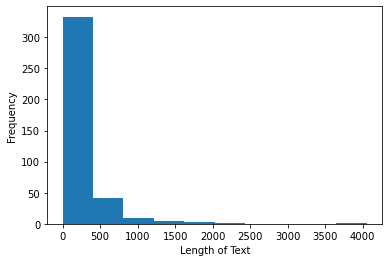

In [8]:
plt.hist(Length)
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.show()

In [10]:
type(NotesSections)

dict

In [13]:
for row,key in enumerate(NotesSections.keys()):
    print(row,key)

0 10034049-DS-19
1 10034049-DS-20
2 10053872-DS-7
3 10071869-DS-19
4 10099592-DS-14
5 10002131-DS-16
6 10015785-DS-16
7 10015785-DS-17
8 10020640-DS-8
9 10024913-DS-19
10 11483216-DS-9
11 13931492-DS-17
12 13977966-DS-14
13 17426206-DS-20
14 17465152-DS-3
15 10013643-DS-23
16 10120109-DS-10
17 10136839-DS-15
18 10139387-DS-20
19 10172708-DS-8


In [35]:
data = NotesSections['10136839-DS-15']

In [36]:
data['temp'] = data['label'] + ": " + data['text']

In [37]:
data

,title,text,label,temp
4,sex,M,Sex,Sex: M
5,service,MEDICINE,Service,Service: MEDICINE
6,allergies,No Known Allergies / Adverse Drug Reactions,Allergies,Allergies: No Known Allergies / Adverse Drug R...
7,attending,___.,Attending,Attending: ___.
8,chief complaint,Planned admission for allogenic stem cell tran...,Chief Complaint,Chief Complaint: Planned admission for allogen...
9,major surgical or invasive procedure,Allogeneic stem cell transplant (___),Major Surgical or Invasive Procedure,Major Surgical or Invasive Procedure: Allogene...
10,history of present illness,___ with no significant medical history with r...,History of Present Illness,History of Present Illness: ___ with no signif...
11,past medical history,TREATMENT COURSE ___ INITIAL BMBX AML ___ I...,Past Medical History,Past Medical History: TREATMENT COURSE ___ IN...
12,discharge date,___ CONDITIONING REGIMEN ___ GVHD Prophylaxis ...,DISCHARGE DATE,DISCHARGE DATE: ___ CONDITIONING REGIMEN ___ G...
13,social history,___,Social History,Social History: ___


In [38]:
note = ' '.join(data['temp'])
note

'Sex: M Service: MEDICINE Allergies: No Known Allergies / Adverse Drug Reactions Attending: ___. Chief Complaint: Planned admission for allogenic stem cell transplant Major Surgical or Invasive Procedure: Allogeneic stem cell transplant (___) History of Present Illness: ___ with no significant medical history with relapsed AML, 24 months (day 694) after MRD allo-transplant s/p reinduction therapy with MEC + Lenalidomide, here for planned admission for second allo transplant with a different, unrelated donor.   The patient initially presented in ___ after several weeks of progressive fatigue and was found to be anemic when  attempting to donate blood to ___. Bone marrow biopsy showed AML and he had his first allogeneic SCT on ___. Over the last few years he had been doing well until recently where he was noted  to have persistent cytopenias despite discontinuing certain bone marrow suppressive medications. Repeat bone marrow biopsy on ___ showed relapsed AML. He subsequently underwent i

In [39]:
note_num = len(tokenizer.tokenize(note))

In [40]:
note_num

5583

In [41]:
import random

In [42]:
# 生成随机索引
random_index = random.randint(0, len(data) - 1)

# 随机删除某一行
data = data.drop(data.index[random_index])

In [54]:
data = NotesSections['10136839-DS-15']
data['temp'] = data['label'] + ": " + data['text']
while len(tokenizer.tokenize(' '.join(data['temp']))) > 4096:
    random_index = random.randint(0, len(data) - 1)
    data = data.drop(data.index[random_index])
    print(len(tokenizer.tokenize(' '.join(data['temp']))))

5578
5412
5369
5366
5151
4352
4346
3551


In [55]:
df = pd.read_csv('mimiciv_discharge.csv')
df = df.loc[[19,18,17],].reset_index(drop=True)

In [34]:
df

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10172708-DS-8,10172708,23556537,DS,8,2138-08-08 00:00:00,2138-08-08 12:59:00,\nName: ___ Unit No: ___\n...
1,10139387-DS-20,10139387,28071978,DS,20,2182-09-30 00:00:00,2182-09-30 10:44:00,\nName: ___ Unit No: ___\n \...
2,10136839-DS-15,10136839,25748321,DS,15,2177-08-02 00:00:00,2177-08-02 16:19:00,\nName: ___ Unit No: ___\n...
